# Required packges and setup

In [47]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace import sarimax
import itertools
import warnings

path = r"/Users/anko/Downloads"
sns.set(rc={'figure.figsize':(11, 4)})
sns.set(style="whitegrid", color_codes=True)

# Datasets

In [2]:
ss_df = pd.read_csv(path + "/MonthlySunshine.csv", index_col=0)
rf_df = pd.read_csv(path + "/MonthlyRainfall.csv", index_col=0)
mt_df = pd.read_csv(path + "/MonthlyMeanTemp.csv", index_col=0)

# Data preprocessing

In [9]:
# Aggregate columns to be dropped.
group_cols = ["win", "spr", "sum", "aut", "ann"]

In [28]:
def df_flatten(df, exclude_cols, series_name, col_name="Value"):
    """ Function to expand the 2-d dataframe (year / month) to 1-d dataframe.
    
    """
    temp = df[df.columns.difference(exclude_cols)]
    # Expand columns and index for flattened index.
    index = [str(x) + "-" + str(y) 
             for x in temp.index 
             for y in temp.columns]
    
    index = [pd.to_datetime(x, format="%Y-%b") for x in index]
    output = pd.DataFrame(temp.values.flatten(), index=index, columns=[col_name])
    output = output.sort_index().dropna()
    output.index = pd.DatetimeIndex(output.index.values,
                               freq=output.index.inferred_freq)
    output['Year'] = output.index.year
    output['Month'] = output.index.month

    output.name = series_name
    
    return output

In [29]:
ss_df_ts = df_flatten(ss_df, group_cols, series_name="Sunshine")
rf_df_ts = df_flatten(rf_df, group_cols, series_name="Rainfall")
mt_df_ts = df_flatten(mt_df, group_cols, series_name="MeanTemp")

In [30]:
# Example of flattened dataset
ss_df_ts.head(5)

,Value,Year,Month
1919-01-01,40.9,1919,1
1919-02-01,52.7,1919,2
1919-03-01,94.4,1919,3
1919-04-01,125.1,1919,4
1919-05-01,227.4,1919,5


# Q1 & Q2 Combined.
### NOTE: Each series will be examined and modelled sequentially and go through Q1 and Q2 contents.

<bold> WARNING: Python calculates the variance of autocorrelation coefficient using Barlett's formula. Hence, the confidence interval may differ to R's results. </bold> 

## Custom functions for visualisation

In [17]:
def preliminary_analysis(df, column, title):
    
    # Preliminary analysis on raw value
    fig, axes = plt.subplots(4, 1, figsize=(11, 10), sharex=False)
    fig.suptitle(df.name + "_" + title, fontsize=16)

    df[column].plot(ax=axes[0])
    df[column].plot(kind='kde',ax=axes[1])
    sns.boxplot(data=df, y=column, x="Month", ax=axes[2])
    sns.boxplot(data=df[-132:-12], y=column, x="Year", ax=axes[3])

    axes[0].set_title("Monthly time-series plot")
    axes[1].set_title("KDE")
    axes[2].set_title("Box plot of monthly series")
    axes[3].set_title("Box plot of annual series")

    fig.tight_layout()
        
    plt.show()

In [18]:
def ts_analysis(df, column, title):
    
    # ACF & PACF
    series = df[column].dropna()

    fig, axes = plt.subplots(1, 2,figsize=(16,6))
    fig.suptitle(title +" with lag 120 months", fontsize=16)

    plot_acf(series, ax=axes[0], lags=120, missing="drop")
    plot_pacf(series, ax=axes[1], lags=120, method="ywm", zero=False)

    fig.tight_layout()
    plt.show()

In [19]:
def combined_visual(df, column, title):
    preliminary_analysis(df, column, title)
    ts_analysis(df, column, title)

## Series 1: Sunshine

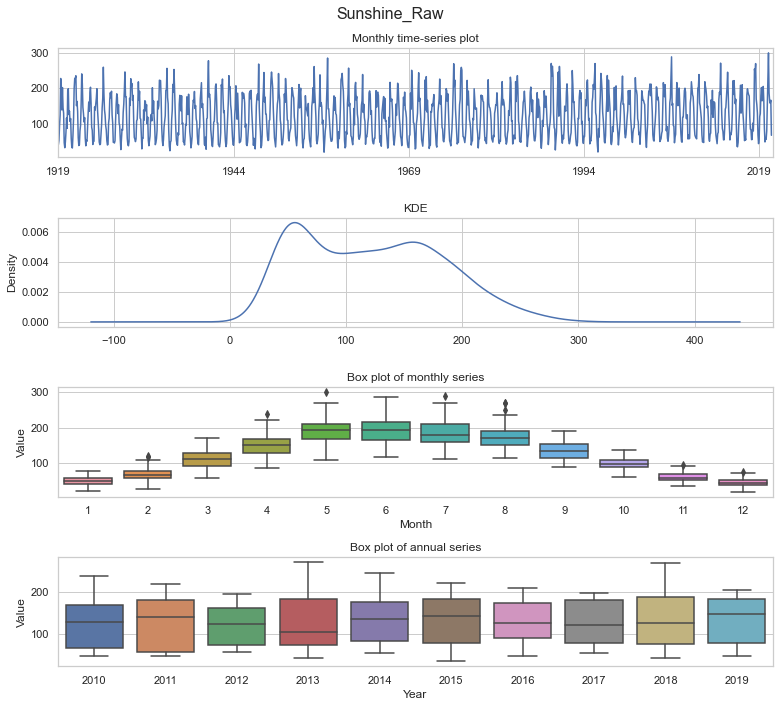

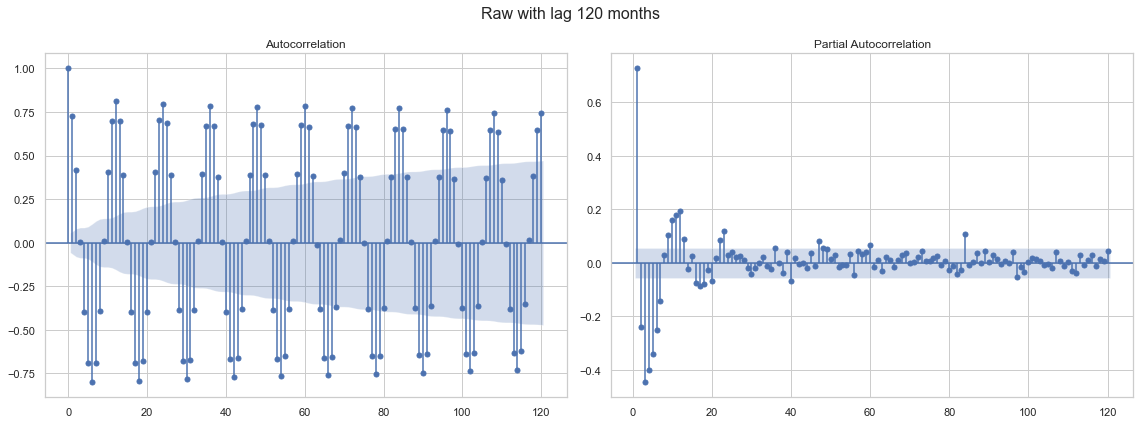

In [20]:
combined_visual(ss_df_ts, "Value", "Raw")

Based on plots with raw dataset above, we can conclude that:
1. Monthly time-series plot shows no clear trend but high fluctuation with a tendancy to revert back to mean.
2. Density plot indicates that this series is not normally distributed.
3. Box plots confirm the monthly seasonality and provide some additional insights:
    * Sunshine is genearlly higher during summer (May - Aug) and lower as winter approaches (Nov, Dec, Jan, Feb). Which is a common climate condition for countries with distinct 4 seasons.
    * There is no clear seasonality observed on annual series.
4. ACF & PACF further confirm the existence of cycles and nonstationarity of this process.
    * ACF decays quickly but with a distinct cycle (seasonality) and PACF also decays quickly (relatively) with a distinct seasonal cycle as well. 
    * Given this is monthly data-series, it is evident that this time-series should exhibit the clear seasonal cycle and this is inline with the expectation that the amount of sunshine would be the same every year and fluctuate around each seasons. (Unless some natural disasters happen such as volcano erruption with heavy dust clouds.)

In [21]:
# 12 month differencing
ss_df_ts["Diff"] = ss_df_ts["Value"].diff()

### Considering sesonal difference (12 Month)

Based on preliminary analysis above, we further proceeds our analysis with seasonally differenced series (with 12 months).

In [22]:
ss_df_ts.head(13)

,Value,Year,Month,Diff
1919-01-01,40.9,1919,1,NaN
1919-02-01,52.7,1919,2,11.8
1919-03-01,94.4,1919,3,41.7
1919-04-01,125.1,1919,4,30.7
1919-05-01,227.4,1919,5,102.3
1919-06-01,207.3,1919,6,-20.1
1919-07-01,138.7,1919,7,-68.6
1919-08-01,201.7,1919,8,63.0
1919-09-01,145.4,1919,9,-56.3
1919-10-01,129.7,1919,10,-15.7


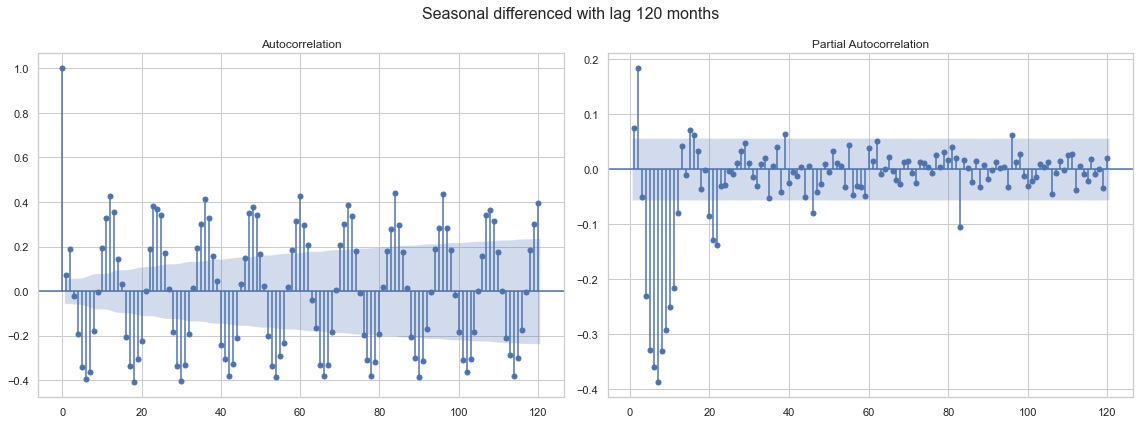

In [23]:
ts_analysis(ss_df_ts, "Diff", "Seasonal differenced")

### ADF test

In [24]:
result = adfuller(ss_df_ts["Diff"].dropna())

In [25]:
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -13.718300
p-value: 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


<p> Based on ACF & PACF plots above, this seasonally differenced series now seems to be more stationary. </p> 
<p> This can be further attested with ADF test. Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure. </p>
<br></br>
Given these results above, this series can be potentially modelled with a multiplicative seasonal ARIMA model. The resulting ACF and PACF indicate that:

1. ACF cuts off at lag 3s and PACF is decaying quickly at the seasonal lags = <strong> MA(3) </strong>
2. ACF & PACF decay quickly at the seasonal lags = <strong> ARMA(2,2) </strong>

<br></br>
<p>Now considering the ACF & PACF of non-seasonal lags, both ACF & PACF is decaying quickly (ACF at lags 3 and PACF could be 1 or more). However, for lower fit of the model, <strong> ARMA(3,1) </strong> will be considered initially and compare the fit of model with higher order of MA (ARMA(3,2) ...). </p>

## Model fitting

$ARIMA(3,0,1) * (2,1,2)_{12}$

In [91]:
# Define the p, d and q parameters to take any value between 0 and 2
p = q = d = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

warnings.filterwarnings("ignore") # specify to ignore warning messages


Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [123]:
ss_model_1 = sarimax.SARIMAX(ss_df_ts["Value"], 
                             order=(0,0,2),
                             seasonal_order=(2,1,0,12))

In [127]:
res_sarimax = ss_model_1.fit(maxiter=300)

In [128]:
print(res_sarimax.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               Value   No. Observations:                 1222
Model:             SARIMAX(0, 0, 2)x(2, 1, [], 12)   Log Likelihood               -5811.714
Date:                             Sun, 22 Nov 2020   AIC                          11633.429
Time:                                     12:48:15   BIC                          11658.921
Sample:                                 01-01-1919   HQIC                         11643.028
                                      - 10-01-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1410      0.025      5.724      0.000       0.093       0.189
ma.L2          0.0839      

In [129]:
def sarimax_forecast(result, observed, step):
    pred_val = result.get_forecast(steps=step) 
    pred_ci = pred_val.conf_int()
    
    ax = observed[-60:].plot(label='observed', figsize=(20, 15))
    pred_val.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel('Delays')
    plt.show()

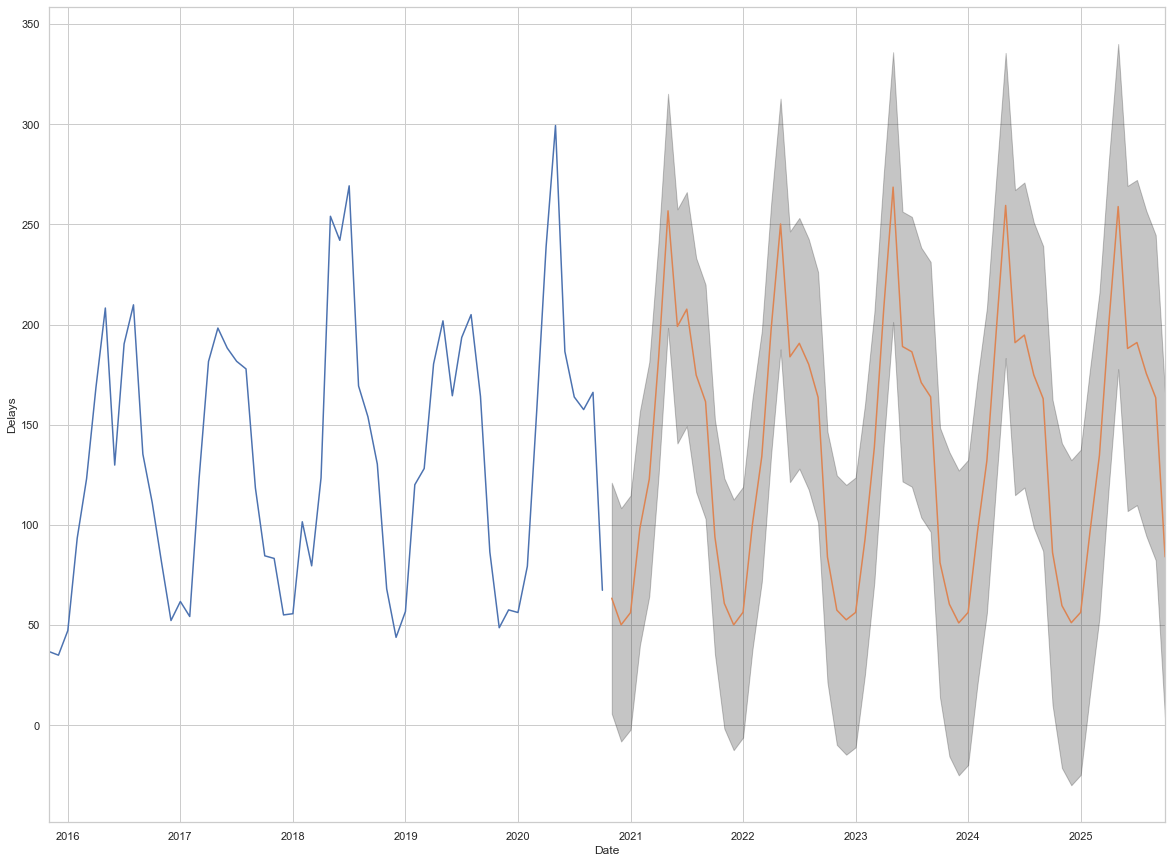

In [130]:
sarimax_forecast(res_sarimax, ss_df_ts["Value"], 60)

## Sreis 2: Rainfall

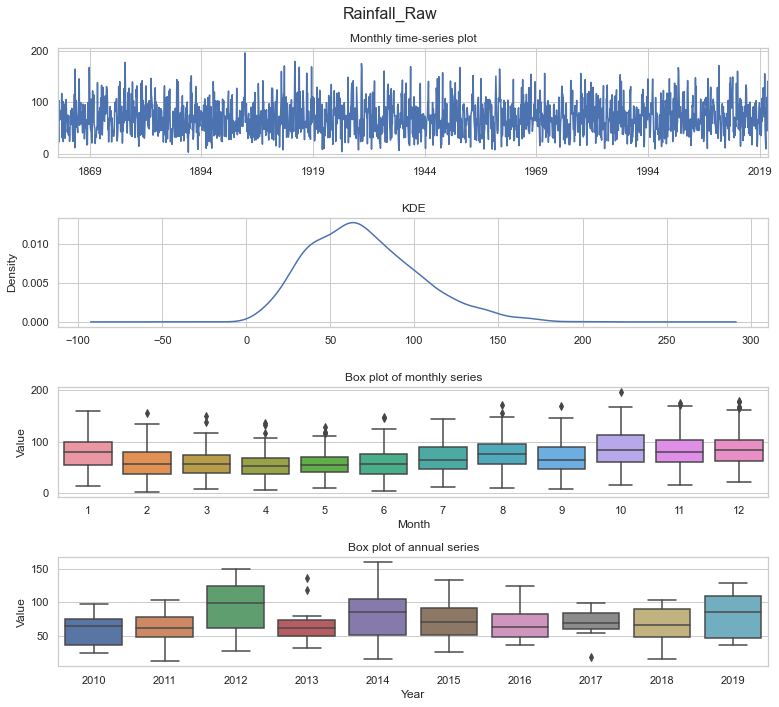

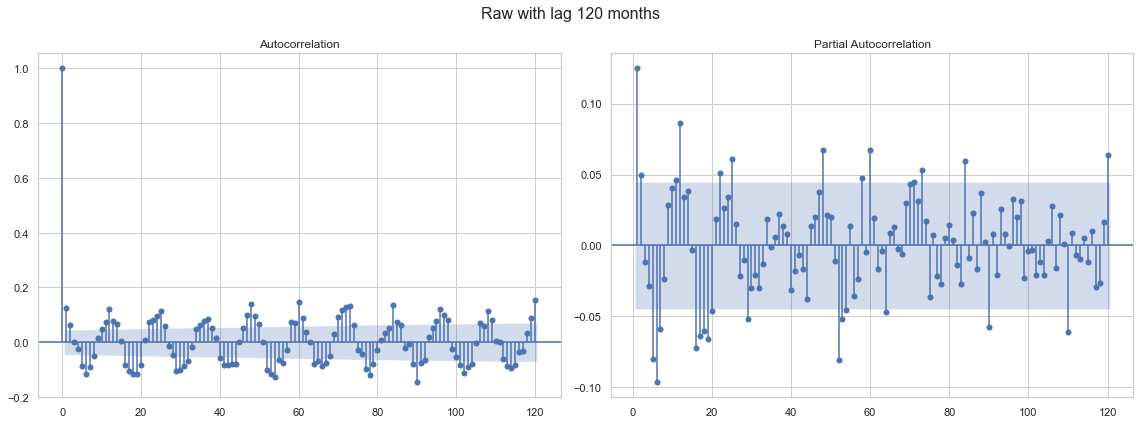

In [488]:
combined_visual(rf_df_ts,  "Value", "Raw")

Based on plots above, we can conclude that:
1. Monthly time-series plot shows no clear trend but high fluctuation with a tendancy to revert back to mean. 
2. Density plot indicates that this series is not normally distributed.
3. Box plots confirm the monthly seasonality with some outliers on certain years (e.g. 2013, 2017 in last 10 years) and provide some additional insights:
    * Rainfall is higher during Aug to Jan and lower during Feb to Jun. This analysis possibly indicates that this rainfall data is from UK (or any regions surrounded by ocean) as generally UK (regions surrounded by ocean) experience humid climates during winter and drier climates during Spring and early Summer compared to other continental countries. 

4. ACF & PACF further confirm the existence of cycles and indicate a potential nonstationarity of this process. However, this needs to be further examined with seasonally differenced data.
    * Given this is monthly data-series, it is evident that this time-series exhibits the clear seasonal lag of 12 and this is inline with the expectation that the amount of rainfall would be the same every year and season.
    * ACF shows a geometric decaying pattern and PACF cut-offs immediately at 2. However, there are some significant lag coefficients every cycle. As mentioned above, this will be further examined with seasonally differenced series. 

### Considering sesonal difference (12 Month)

Based on preliminary analysis above, we further proceeds our analysis with seasonally differenced series (with 12 months).

In [498]:
# 12 month differencing
rf_df_ts["Diff"] = rf_df_ts["Value"].diff(12)

In [499]:
rf_df_ts.head(15)

,Value,Year,Month,Diff
1862-01-01,68.1,1862,1,NaN
1862-02-01,22.7,1862,2,NaN
1862-03-01,103.1,1862,3,NaN
1862-04-01,65.0,1862,4,NaN
1862-05-01,84.1,1862,5,NaN
1862-06-01,74.2,1862,6,NaN
1862-07-01,75.0,1862,7,NaN
1862-08-01,67.0,1862,8,NaN
1862-09-01,75.6,1862,9,NaN
1862-10-01,116.9,1862,10,NaN


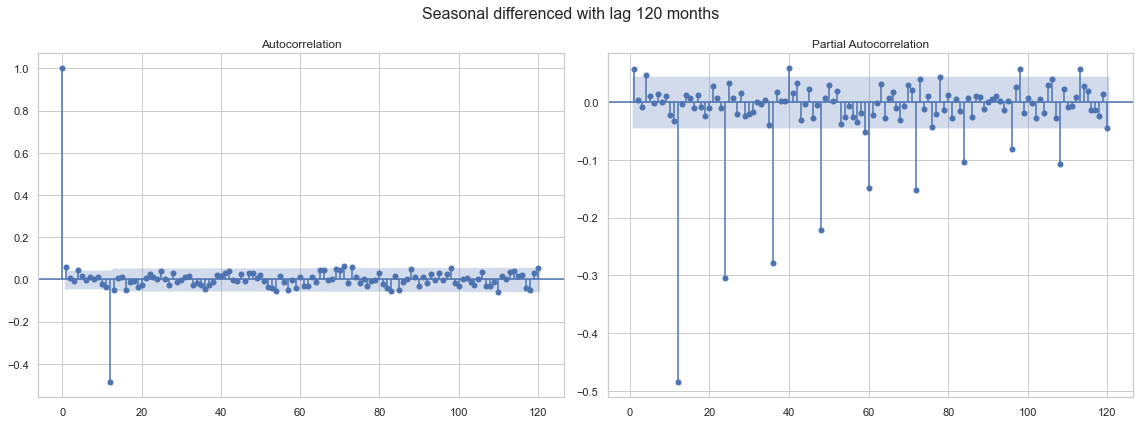

In [500]:
ts_analysis(rf_df_ts, "Diff", "Seasonal differenced")

### ADF test

In [492]:
result = adfuller(rf_df_ts["Diff"].dropna())

In [493]:
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -13.457246
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


Based on ACF & PACF plots above, this seasonally differenced series now seems to be more stationary than raw-series. This can be further attested with ADF test. Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure. Given these results above, this series can be potentially modelled with a multiplicative seasonal ARIMA model.

### Mean Temperature

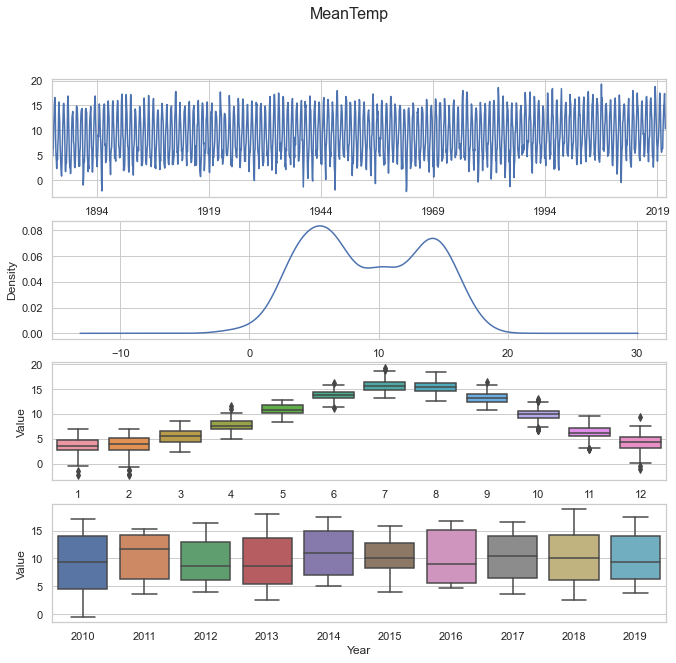

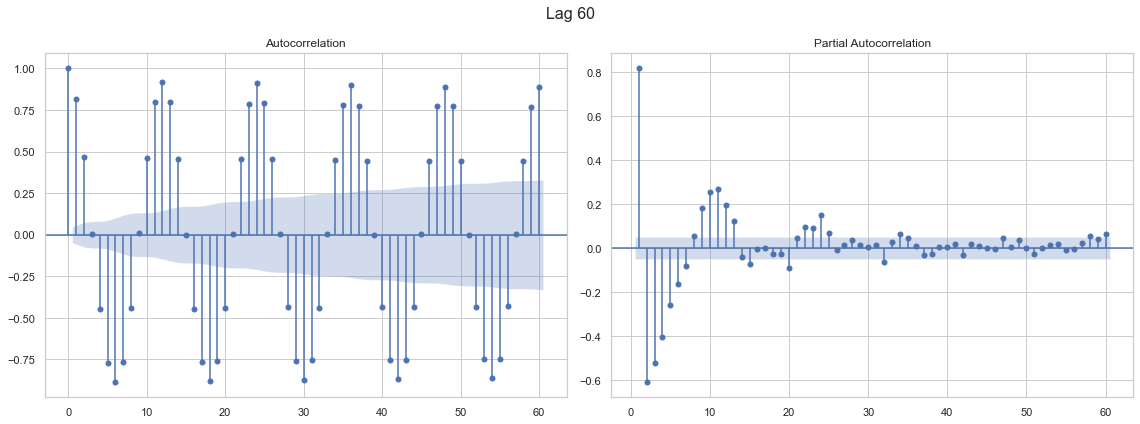

In [388]:
combined_visual(mt_df_q1)

Based on plots above, we can conclude that:
- Monthly time-series plot shows no clear trend (maybe the mean value increased slightly but not definite) but high fluctuation with a tendancy to revert back to mean. 
- Density plot indicates that this series is not normally distributed.
- Box plots confirm the strong monthly seasonality and provide some additional insights:
    * Mean temperature is higher during summer and lower during winter (Which is obvious).

- ACF & PACF further confirm the existence of cycles and nonstationarity of this process.
    * Given this is monthly data-series, it is evident that this time-series exhibits the clear seasonal lag of 12 and this is inline with the expectation that the amount of rainfall would be the same every year and season.